<a href="https://colab.research.google.com/github/ENV716/Energy_Modeling_F2022/blob/main/Lab/Lab08/Lab08_GasolineBlending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 08 - Gasoline Blending model in Python**


## Initializing 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

Mounted at /content/drive


Installing Pyomo and glpk solver.

In [2]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 7.7 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Pr

Importing pyomo and solver.

In [3]:
from pyomo.environ import *
#Import solver
opt=SolverFactory('glpk')

## Problem Formulation

Recall the gasoline blending example. You need to find how to produce three types of gasoline from three available stocks so that **profits are maximized**.  The blended gasoline must meet minimum octane rating. The amount of each type of gasoline produced cannot exceed demand. It is not possible to use more stocks than what is available. 


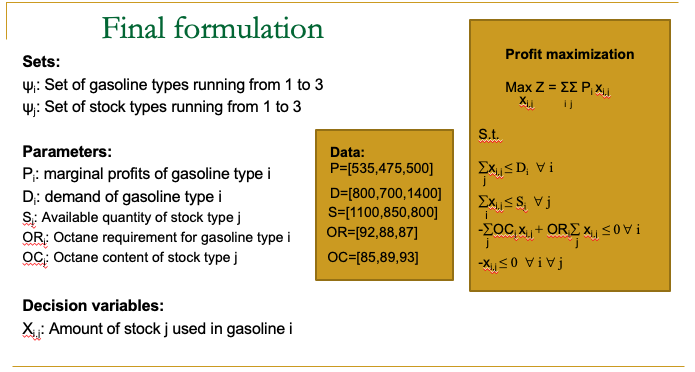

## Defining model, sets, parameters

In [4]:
#Initialize Model
model=ConcreteModel()

#Defining Sets
model.I=Set(initialize=['G1','G2','G3'])  #set of gasoline types running from 1 to 3
model.J=Set(initialize=['SA','SB','SC'])  #set of stock types running from 1 to 3

#Defining Parameters
model.P=Param(model.I,initialize={'G1':535,'G2':475,'G3':500})   #profit margin
model.D=Param(model.I,initialize={'G1':800,'G2':700,'G3':1400})  #forecasted demand
model.S=Param(model.J,initialize={'SA':1100,'SB':850,'SC':800})  #quantity available for each stock
model.OR=Param(model.I,initialize={'G1':92,'G2':88,'G3':87})     #minimum octane rating for each gasoline type
model.OC=Param(model.J,initialize={'SA':85,'SB':89,'SC':93})     #octane rating from stocks

## Defining decision variables

In [ ]:
#Add dec variables
model.x=Var(model.I,model.J,domain=NonNegativeReals)

## Defining objective function

Remember we want to maximize profit from gasoline sales.

In [5]:
#Add obj func
def obj_profit(model):
    return sum(sum(model.P[i]*model.x[i,j] for j in model.J) for i in model.I)
model.profit=Objective(sense=maximize,rule=obj_profit)

#Checking objetive function
print(model.profit.expr)

#Exercise: Change order of i and j inside the sums to see how the order of elements will change

535*x[G1,SA] + 535*x[G1,SB] + 535*x[G1,SC] + 475*x[G2,SA] + 475*x[G2,SB] + 475*x[G2,SC] + 500*x[G3,SA] + 500*x[G3,SB] + 500*x[G3,SC]


## Adding model constrains
* Market demand: quantity of gasoline produced should be less than or equal to demand

* Stock availability: quantity of stocks used should be less than or equal to the amount available

* Minimum octane rating: octane rating of gasoline should be greater than or equal to minimum octane rating requirement

* Non-negativity constraints: already added when we defined the decison variables


In [6]:
#Add market demand constraint for all gasoline types
def meet_demand(model,i):
    return sum(model.x[i,j] for j in model.J) <= model.D[i]
model.demand=Constraint(model.I,rule=meet_demand)

#Checking added constraints
for i in model.I:
    print(model.demand[i].expr)


x[G1,SA] + x[G1,SB] + x[G1,SC]  <=  800
x[G2,SA] + x[G2,SB] + x[G2,SC]  <=  700
x[G3,SA] + x[G3,SB] + x[G3,SC]  <=  1400


In [7]:
#Add stock availability constraint
def supply_avail(model,j):
    return sum(model.x[i,j] for i in model.I) <= model.S[j]
model.supply=Constraint(model.J,rule=supply_avail)

#Checking added constraints
for j in model.J:
    print(model.supply[j].expr)


x[G1,SA] + x[G2,SA] + x[G3,SA]  <=  1100
x[G1,SB] + x[G2,SB] + x[G3,SB]  <=  850
x[G1,SC] + x[G2,SC] + x[G3,SC]  <=  800


In [8]:
#Add octane rating constraint
def rating_conc(model,i):
    return ( model.OR[i]*sum(model.x[i,j] for j in model.J) <= sum(model.OC[j]*model.x[i,j] for j in model.J) )
model.rating=Constraint(model.I,rule=rating_conc)

#Checking added constraints
for i in model.I:
    print(model.rating[i].expr)


92*(x[G1,SA] + x[G1,SB] + x[G1,SC])  <=  85*x[G1,SA] + 89*x[G1,SB] + 93*x[G1,SC]
88*(x[G2,SA] + x[G2,SB] + x[G2,SC])  <=  85*x[G2,SA] + 89*x[G2,SB] + 93*x[G2,SC]
87*(x[G3,SA] + x[G3,SB] + x[G3,SC])  <=  85*x[G3,SA] + 89*x[G3,SB] + 93*x[G3,SC]


## Solving the model and reporting results


In [9]:
#Solve model
opt.solve(model)

#Print results
print("Profit =",model.profit())
for i in model.I:
  for j in model.J:
    print(model.x[i,j],model.x[i,j].value)

Profit = 1385500.0
x[G1,SA] 92.1875
x[G1,SB] 0.0
x[G1,SC] 645.3125
x[G2,SA] 307.8125
x[G2,SB] 150.0
x[G2,SC] 154.6875
x[G3,SA] 700.0
x[G3,SB] 700.0
x[G3,SC] 0.0
